In [1]:
from collections import defaultdict

from IPython.display import Image

from nems.db import pd_query
from nems_lbhb.baphy_experiment import BAPHYExperiment
from nems.xform_helper import fit_model_xform

from src.visualization.interactive import plot_raw_pair

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-04-05 165423.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


## Find neurons with lots of stim
in particular interested in neurons that besides my experiment (CPN) also have either Natural sounds (NAT) and or Sam's Experiment (NTI)

In [2]:
def get_exp_cells(runclass):
    querry = f"SELECT gSingleCell.siteid, gSingleCell.cellid, gRunClass.name FROM ((gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid) INNER JOIN  gRunClass on sCellFile.runclassid=gRunClass.id) WHERE gRunClass.name = '{runclass}'"
    # print(BF_querry)
    df = pd_query(querry)
    return df
cpn = set(get_exp_cells('CPN').cellid)
nti = set(get_exp_cells('NTI').cellid)
nat = set(get_exp_cells('NAT').cellid)

common = cpn.intersection(nti).intersection(cpn)
print(f'{len(common)} common neurons')
print(common)


1623 common neurons
{'ARM027a-09-11', 'TNC018a-19-3', 'ARM022b-42-1', 'TNC016a-11-1', 'ARM024a-28-1', 'CRD003b-33-2', 'ARM024a-36-6', 'ARM019a-10-5', 'AMT026a-19-2', 'AMT028b-15-2', 'ARM025a-11-2', 'AMT028b-16-1', 'ARM033a-58-1', 'AMT031a-34-2', 'ARM024a-51-4', 'ARM021b-12-9', 'DRX023a-14-1', 'ARM022b-57-1', 'ARM019a-36-4', 'CRD005b-19-1', 'ARM032a-18-3', 'DRX008b-98-2', 'CRD003b-13-1', 'ARM029a-22-2', 'AMT028b-28-2', 'CRD019b-19-2', 'CRD005b-21-1', 'DRX008b-23-1', 'TNC016a-52-4', 'ARM021b-04-3', 'CRD004a-61-3', 'CRD002a-18-1', 'ARM019a-20-6', 'TNC018a-18-2', 'DRX008b-71-6', 'TNC023a-39-2', 'CRD014b-18-3', 'ARM022b-35-1', 'ARM025a-16-5', 'TNC018a-33-2', 'TNC017a-31-3', 'CRD005b-24-1', 'ARM022b-01-6', 'DRX008b-123-9', 'ARM026b-13-3', 'TNC017a-13-3', 'TNC018a-50-1', 'TNC017a-25-7', 'ARM031a-45-7', 'TNC014a-43-2', 'AMT028b-48-1', 'CRD002a-38-1', 'ARM027a-09-10', 'DRX008b-94-3', 'CRD005b-49-1', 'TNC023a-58-2', 'DRX021a-10-2', 'ARM031a-54-3', 'DRX008b-69-3', 'CRD018d-29-1', 'AMT028b-07-1', 

# Filter for stim parameters
get only CPN sites with 10 permutations??

In [3]:
# finds the raw ids for  AllPermutations experiments
querry = f"SELECT rawid FROM gData where name = 'Ref_SequenceStructure' and svalue = 'AllPermutations'"
df = pd_query(querry)
rawids = tuple(df.rawid)

# with those raw ids, filter for those raw ids wher there were 10 sounds
querry = f"SELECT rawid, svalue FROM gData where name = 'Ref_SoundIndexes' and rawid in {rawids}"
df = pd_query(querry)
df['nsounds'] = df['svalue'].apply(lambda x: len([int(i) for i in x[1:-1].split(' ')]))
rawids = tuple(df.query('nsounds == 10').rawid)

# finally finds the subset of sites/cells that fulfill all conditions
querry = f"SELECT cellid FROM gDataRaw where id in {rawids}"
siteids = tuple(pd_query(querry).cellid)

# get only those cpn cells that belong to the good 10 permutations sites
cpn = set(get_exp_cells('CPN').query(f"siteid in {siteids}").cellid)
common = cpn.intersection(nti)
site_dict =  defaultdict(list)
for cellid in common:
    site_dict[cellid[:7]].append(cellid)

print(f'{len(common)} total CPN(10sound) NTI neurons, across {len(site_dict.keys())} sites')
print(list(site_dict.keys()))
# there is no common CPN10 and nat neurons.

469 total CPN(10sound) NTI neurons, across 9 sites
['TNC018a', 'TNC016a', 'TNC017a', 'TNC010a', 'TNC015a', 'TNC014a', 'TNC024a', 'TNC023a', 'TNC009a']


# Load one example site

In [4]:
print(site_dict.keys())

options = {'stimfmt': 'envelope',
           'rasterfs': 100,
           'runclass': 'CPN',
           'stim': False,
           'resp':True,
           'recache': False}

# manager = BAPHYExperiment(cellid=site, batch=options['batch'])

dict_keys(['TNC018a', 'TNC016a', 'TNC017a', 'TNC010a', 'TNC015a', 'TNC014a', 'TNC024a', 'TNC023a', 'TNC009a'])


In [5]:
eg_site = 'CRD018d'
eg_site = 'TNC014a'


options = {'stimfmt': 'ozgf',
           'chancount': 18,
           'rasterfs': 100,
           'stim': True,
           'resp':True,
           'recache': False,
           'runclass': None,
           'includeprestim': True}
manager = BAPHYExperiment(cellid=eg_site, batch=326)

loaded_rec = manager.get_recording(**options)
parameters = manager.get_baphy_exptparams()

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/326/TNC014a_3ea0bd53034b29d099c0aba991eaeb62cdd6bede.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a07_p_NTI.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a07_p_NTI.evp
/auto/users/mateo/code/nems_db/nems_lbhb/baphy_io.py:376: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exptevents = exptevents.append(lick_events, ignore_index=True)
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.evp
/auto/users/mateo/code/nems_db/nems_lbhb/baphy_io.py:376: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

# Run some test model fit

[nems.xform_helper INFO] Initializing modelspec(s) for cell/batch TNC014a-22-2/326...
[nems.xform_helper INFO] TODO: simplify generate_xforms_spec parameters
[nems.xform_helper INFO] Initializing modelspec(s) for recording/model None/ozgf.fs100.ch18-ld.popstate-dline.15.15.1-norm-epcpn.seq-avgreps_dlog-wc.18x1.g-fir.1x15-lvl.1-dexp.1-stategain.S.d_aev-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont...
[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/326/TNC014a_3d117f88831c42fa5d682486af324da48145b6ba.tgz
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument cellid overlaps with existing context key: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) ['TNC014a-22-2']
[nems.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems.xf

/auto/data/nems_db/results/326/TNC014a-22-2/ozgf.fs100.ch18-ld.popstate-dline.15.15.1-norm-epcpn.seq-avgreps.dlog-wc.18x1.g-...6189816521702395425 /auto/data/nems_db/results/326/TNC014a-22-2/ozgf.fs100.ch18-ld.popstate-dline.15.15.1-norm-epcpn.seq-avgreps.dlog-wc.18x1.g-...6189816521702395425


[nems.xforms INFO] ----------------------------------------------------
[nems.xforms INFO] Fitting: nems.tf.cnnlink_new.fit_tf_init, fit 1/1, fold 1/1
[nems.tf.cnnlink_new INFO] up_to_idx=3 (nems.modules.levelshift.levelshift)
[nems.tf.cnnlink_new INFO] Creating temporary model for init
[nems.tf.cnnlink_new INFO] nems.modules.nonlinearity.dlog
[nems.tf.cnnlink_new INFO] nems.modules.weight_channels.gaussian
[nems.tf.cnnlink_new INFO] nems.modules.fir.basic
[nems.tf.cnnlink_new INFO] nems.modules.levelshift.levelshift
[nems.tf.cnnlink_new INFO] Fixing "nems.modules.levelshift.levelshift" to: 0.046
[nems.tf.cnnlink_new INFO] Running first init fit: model up to last lvl/relu without stp/gain.
[nems.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.tf.cnnlink_new INFO] Feature dimensions: (1, 27400, 18); Data dime

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[tensorflow WARNING] AutoGraph could not transform <bound method FIR.call of <nems.tf.layers.FIR object at 0x7fa5db379160>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[nems.tf.modelbuilder INFO] Built model, printing summary.
[nems.tf.modelbuilder INFO] Model: "Test-model"
[nems.tf.modelbuilder INFO] __________________________________________________________________________________________________
[nems.tf.modelbuilder INFO] Layer (type)                    Output Shape         Param #     Connected to                     
[nems.tf.modelbuilder INFO] ==================================================================================================
[nems.tf.modelbuilder INFO] stim (InputLayer)               [(None, 27400, 18)]  0                                            
[nems.tf.modelbuilder INFO] __________________________________________________________________________________________________
[nems.tf.modelbuilder INFO] dlog (Dlog)                     (None, 27400, 18)    1           stim[0][0]                       
[nems.tf.modelbuilder INFO] __________________________________________________________________________________________________
[nem

Epoch 00001/10000 - loss: 0.5765 - pearson: 0.3730
Epoch 00050/10000 - loss: 0.5155 - pearson: 0.3992
Epoch 00100/10000 - loss: 0.4824 - pearson: 0.4488
Epoch 00150/10000 - loss: 0.4668 - pearson: 0.4695
Epoch 00200/10000 - loss: 0.4603 - pearson: 0.4788
Epoch 00250/10000 - loss: 0.4575 - pearson: 0.4833
Epoch 00300/10000 - loss: 0.4560 - pearson: 0.4859
Epoch 00350/10000 - loss: 0.4549 - pearson: 0.4876
Epoch 00400/10000 - loss: 0.4542 - pearson: 0.4889
Epoch 00450/10000 - loss: 0.4537 - pearson: 0.4898
Epoch 00500/10000 - loss: 0.4532 - pearson: 0.4906
Epoch 00550/10000 - loss: 0.4529 - pearson: 0.4912
Epoch 00600/10000 - loss: 0.4525 - pearson: 0.4917
Epoch 00650/10000 - loss: 0.4523 - pearson: 0.4922
Restoring model weights from the end of the best epoch.
Epoch 00678: early stopping


[nems.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 6.311916279048982e-09
[nems.tf.cnnlink_new INFO] ***********************************************************************************
[nems.tf.cnnlink_new INFO] ****   fit_tf_init, fit_index=0 cell_index=0 fitting output NL    ****
[nems.tf.cnnlink_new INFO] Initializing static nl "nems.modules.nonlinearity.double_exponential" at layer #4
[nems.initializers INFO] Init dexp: {'amplitude': array([[0.22259592]]), 'base': array([[-0.00991449]]), 'kappa': array([[0.]]), 'shift': array([[0.]])}
[nems.tf.cnnlink_new INFO] Running second init fit: not frozen but coarser tolerance.
[nems.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.recording INFO] No mask exists, apply

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[nems.tf.modelbuilder INFO] Built model, printing summary.
[nems.tf.modelbuilder INFO] Model: "Test-model"
[nems.tf.modelbuilder INFO] __________________________________________________________________________________________________
[nems.tf.modelbuilder INFO] Layer (type)                    Output Shape         Param #     Connected to                     
[nems.tf.modelbuilder INFO] ==================================================================================================
[nems.tf.modelbuilder INFO] stim (InputLayer)               [(None, 27400, 18)]  0                                            
[nems.tf.modelbuilder INFO] __________________________________________________________________________________________________
[nems.tf.modelbuilder INFO] dlog_1 (Dlog)                   (None, 27400, 18)    1           stim[0][0]                       
[nems.tf.modelbuilder INFO] __________________________________________________________________________________________________
[nem

Epoch 00001/10000 - loss: 0.7850 - pearson: -4.6379e-02
Epoch 00050/10000 - loss: 0.5568 - pearson: 0.2608
Epoch 00100/10000 - loss: 0.5431 - pearson: 0.3030
Epoch 00150/10000 - loss: 0.5330 - pearson: 0.3319
Epoch 00200/10000 - loss: 0.5221 - pearson: 0.3608
Epoch 00250/10000 - loss: 0.5089 - pearson: 0.3927
Epoch 00300/10000 - loss: 0.4916 - pearson: 0.4310
Epoch 00350/10000 - loss: 0.4706 - pearson: 0.4712
Epoch 00400/10000 - loss: 0.4523 - pearson: 0.4997
Epoch 00450/10000 - loss: 0.4403 - pearson: 0.5159
Epoch 00500/10000 - loss: 0.4331 - pearson: 0.5257
Epoch 00550/10000 - loss: 0.4286 - pearson: 0.5319
Epoch 00600/10000 - loss: 0.4260 - pearson: 0.5356
Epoch 00650/10000 - loss: 0.4243 - pearson: 0.5379
Epoch 00700/10000 - loss: 0.4233 - pearson: 0.5393
Epoch 00750/10000 - loss: 0.4227 - pearson: 0.5403
Epoch 00800/10000 - loss: 0.4222 - pearson: 0.5410
Epoch 00850/10000 - loss: 0.4218 - pearson: 0.5416
Epoch 00900/10000 - loss: 0.4214 - pearson: 0.5422
Epoch 00950/10000 - loss: 

[nems.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 7.096159676837501e-09
[nems.xforms INFO] Evaluating: nems.xforms.fit_wrapper
[nems.xforms INFO] ----------------------------------------------------
[nems.xforms INFO] Fitting: nems.tf.cnnlink_new.fit_tf, fit 1/1, fold 1/1
[nems.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.tf.cnnlink_new INFO] Feature dimensions: (1, 27400, 18); Data dimensions: (1, 27400, 1).
[nems.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.tf.cnnlink_new INFO] State dimensions: (1, 27400, 59)
[nems.tf.modelbuilder 

Epoch 00001/10000 - loss: 0.4220 - pearson: 0.5413
Epoch 00050/10000 - loss: 0.4219 - pearson: 0.5415
Epoch 00100/10000 - loss: 0.4218 - pearson: 0.5417
Epoch 00150/10000 - loss: 0.4217 - pearson: 0.5418
Epoch 00200/10000 - loss: 0.4216 - pearson: 0.5420
Epoch 00250/10000 - loss: 0.4215 - pearson: 0.5421
Restoring model weights from the end of the best epoch.
Epoch 00252: early stopping


[nems.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 7.765831104993314e-09
[nems.xforms INFO] Evaluating: nems.xforms.predict
[nems.xforms INFO] Evaluating: nems.xforms.add_summary_statistics
[nems.xforms INFO] cell_index: 0
[nems.xforms INFO] Skipping jackknife MI calculations
[nems.metrics.state INFO] state_mod_index for pred, state_raw, TNC014a-01-2
/auto/users/mateo/code/NEMS/nems/metrics/state.py:68: RuntimeWarning: Mean of empty slice
  high = stat(folded_psth[gtidx, :, :], axis=0).T
[nems.metrics.state INFO] state_mod_index for pred, state_raw, TNC014a-04-2
/auto/users/mateo/code/NEMS/nems/metrics/state.py:68: RuntimeWarning: Mean of empty slice
  high = stat(folded_psth[gtidx, :, :], axis=0).T
[nems.metrics.state INFO] state_mod_index for pred, state_raw, TNC014a-04-3
[nems.metrics.state INFO] state_mod_inde

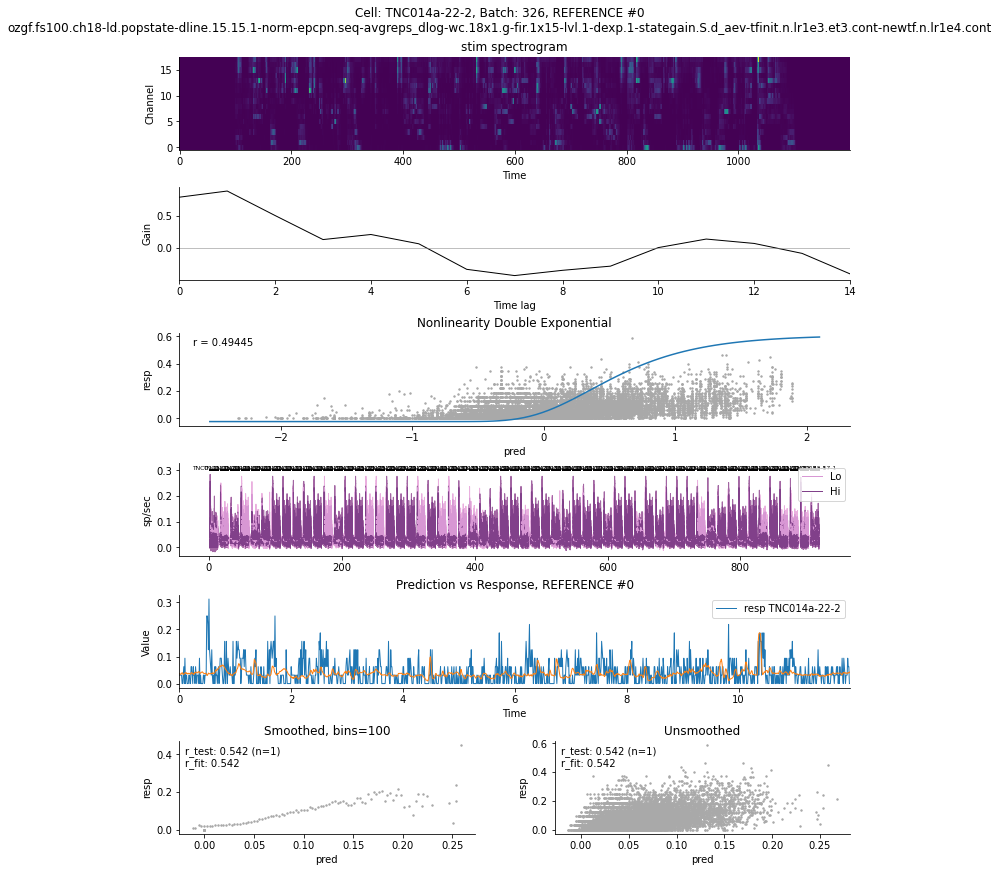

[nems.recording INFO] No mask exists, apply_mask() simply copying recording.
[nems.recording INFO] No mask exists, apply_mask() simply copying recording.


est shape (1, 27400)
val shape (1, 27400)


In [6]:
cellid = 'TNC014a-22-2'
batch = 326

modelname="ozgf.fs100.ch18-ld.popstate-dline.15.15.1-norm-epcpn.seq-avgreps_" \
          "dlog-wc.18x1.g-fir.1x15-lvl.1-dexp.1-stategain.S.d_" \
          "aev-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont"


xfspec,ctx=fit_model_xform(cellid, batch, modelname, autoPlot=True, saveInDB=False, returnModel=True)

import matplotlib.pyplot as plt
plt.show()

est=ctx['est'].apply_mask()
print('est shape',est['resp'].shape)
val=ctx['val'].apply_mask()
print('val shape',val['resp'].shape)


# try to run some of my analysis on the fit

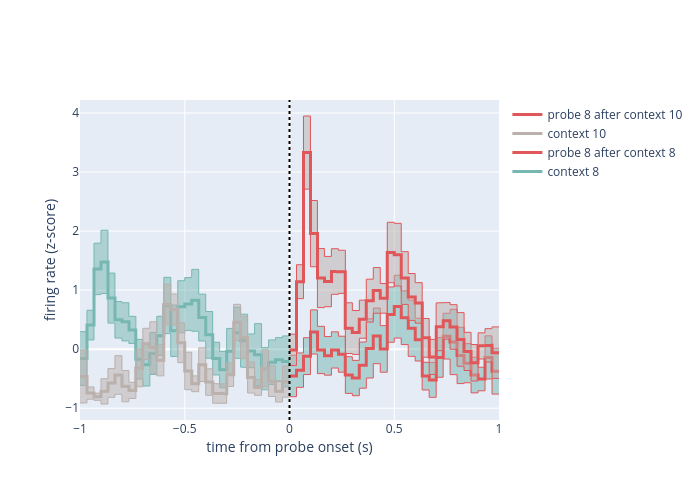

In [7]:
# signal_reliability(ctx['val']['resp'], r'\ASTIM_sequence*', threshold=0.1)
fig = plot_raw_pair(cellid, contexts=[8,10], probe=8, modelspec=modelname, ctx=ctx)
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# Alternatively load cluster-fitted model

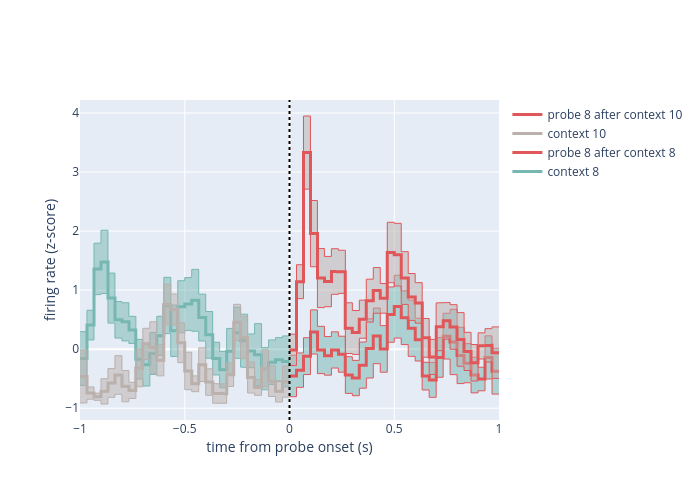

In [8]:
cellid = 'TNC014a-22-2'
batch = 326

modelname="ozgf.fs100.ch18-ld.popstate-dline.10.15-norm-epcpn.seq-avgreps_" \
          "dlog-wc.18x1.g-fir.1x15-lvl.1-dexp.1-stategain.S.d_" \
          "jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred"


fig = plot_raw_pair(cellid, contexts=[8,10], probe=8, modelspec=modelname, batch=326)
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Now compares with the real data

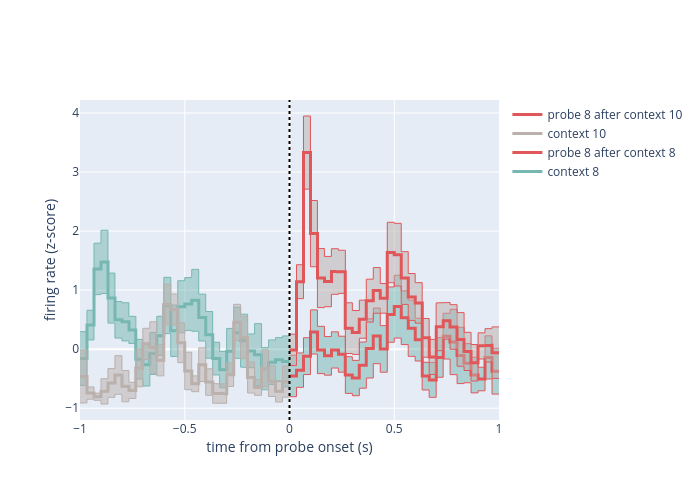

In [9]:
fig = plot_raw_pair(cellid, contexts=[8,10], probe=8, batch=326)
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)